In [1]:
file_path = '/home/krispy_noodles/SIT_Chatbot/assets/SIT User Study.xlsx'

In [8]:
def preference():
    """
    Function to plot comparisons between Chatbot and Manual Search metrics from an Excel sheet,
    including average lines on the line graph and bar graph, using SIT-inspired colors.

    Parameters:
    - file_path: str, path to the Excel file.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # SIT-inspired color palette
    sit_colors = ['#FF1F1F', '#000000', '#FFFFFF', '#F0F0F0', '#808080']

    # Load the sheet
    df = pd.read_excel(file_path, sheet_name='Feedback')
    
    # Clean the DataFrame
    df_cleaned = df.dropna().reset_index(drop=True)
    
    # Standardize column names to avoid formatting issues 
    df_cleaned.columns = df_cleaned.columns.str.strip()
    
    # Count unique values for both categories
    end_study_preference = df_cleaned["Which do they prefer?"].value_counts()

        # Function to create pie chart with labels including total count and a black edge
    def plot_pie_chart(data, title, colors):
        labels = [f"{label} ({count})" for label, count in zip(data.index, data.values)]
        plt.figure(figsize=(6, 6))
        wedges, texts, autotexts = plt.pie(data, labels=labels, autopct='%1.1f%%', colors=colors,
                                           textprops={'fontsize': 11}, wedgeprops={'edgecolor': 'black'})
        plt.title(title, fontweight="bold")
        plt.show()

    # # Create labels with total numbers
    # labels = [f"{label} ({count})" for label, count in zip(end_study_preference.index, end_study_preference.values)]

    # # Plot pie chart for 'SIT Students'
    # plt.figure(figsize=(6, 6))

    plot_pie_chart(end_study_preference, "Which do they prefer?", [sit_colors[0], sit_colors[2]])

    # plt.pie(end_study_preference, labels=labels, autopct='%1.1f%%', colors=[sit_colors[0], sit_colors[4]], textprops={'fontsize': 11})
    # plt.title("Which do they prefer?", fontweight="bold")
    # plt.show()

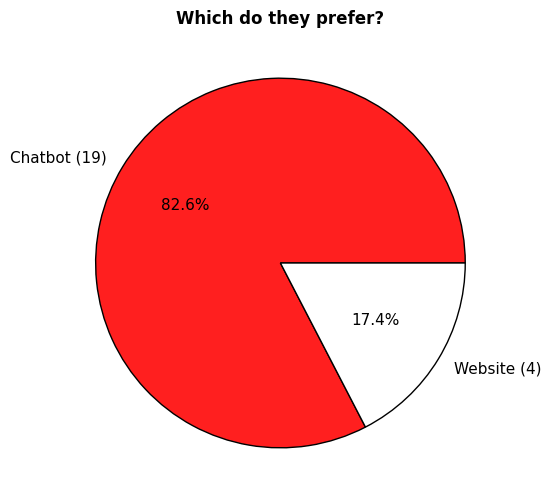

In [9]:
preference()